In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

from spec_bin import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
def mu_U(x,a,b): 
    with np.errstate(invalid='ignore'):
        return (8/(np.pi*(b-a)**2))*np.sqrt((x-a)*(b-x))
    
def mu_mp(x,d):
     with np.errstate(divide='ignore',invalid='ignore'):
        return 1/(2*np.pi*d)*np.sqrt((x-(1-np.sqrt(d))**2)*((1+np.sqrt(d))**2-x))/x

In [4]:
def construct_H(n,k=-1,d=.5):
    """
    n : int, size of T
    k : int, size of Tk
    """
    if k==-1:
        k=n
    
    m = int(n/d)
    
    a = np.zeros(k)
    b = np.zeros(k-1)
    for j in range(k):
        a[j] = np.random.chisquare(df=(m-(j+1)))

    for j in range(k-1):
        b[j] = np.random.chisquare(df=(n-(j+1)))
    
    b = np.sqrt(b) / (np.sqrt(m))
    a = np.sqrt(a) / (np.sqrt(m))
    
    T = sp.sparse.spdiags(a,0,k,k)+sp.sparse.spdiags(b,1,k,k)
    
    return T@T.T

In [5]:
n = 1000000
nz = n//10
d = 0.3;

z = 1.5

a=(1-np.sqrt(d))**2
b=(1+np.sqrt(d))**2

intervals_raw = np.array([[z,z],[a,b]])
intervals = intervals_raw + np.array([[0,0],[-1,1]]) * 0.001

a,b = np.min(intervals),np.max(intervals)
weights = np.array([.2,.8])

In [6]:
if False:
    np.random.seed(0)
    A = sp.sparse.block_diag((construct_H(n-nz,n-nz,d),\
                              #-construct_H(n2,n2,d2),\
                              sp.sparse.spdiags(z+1e-10*np.random.randn(nz),0,nz,nz)))

    lam,Q = np.linalg.eigh(A.A)

    for l in np.reshape(intervals_raw,-1):
        plt.axvline(l,color='k',lw=1)

    plt.hist(lam,100);

In [7]:
mu = lambda x,a,b: mu_U(x,a,b)

def mu2(x):
    mu_x = np.zeros_like(x)
    l = len(weights)
    for i in range(l):
        mask = (intervals[i,0]<x)*(x<intervals[i,1])
        mu_x[mask] += weights[i]*mu(x[mask],intervals[i,0],intervals[i,1])
    return mu_x

In [8]:
k = 100
s = 2*k

αU = np.ones(s+1)*(a+b)/2
βU = np.ones(s+1)*(b-a)/4

αU_unscaled = np.zeros(s+1)
βU_unscaled = np.ones(s+1)/2

α2,β2 = get_op_recurrence(intervals,weights,αU_unscaled,βU_unscaled,s)

In [9]:
np.random.seed(0)
n_trials = 10

α  = np.zeros((n_trials,k))
β  = np.zeros((n_trials,k))
mU = np.zeros((n_trials,k+1))
m2 = np.zeros((n_trials,k+1))

for trial_idx in range(n_trials):
    
    clear_output(wait=True)
    print(trial_idx)
    A = sp.sparse.block_diag((construct_H(n-nz,n-nz,d),\
                              sp.sparse.spdiags(z+1e-10*np.random.randn(nz),0,nz,nz)))

    v = np.sign(np.random.rand(n)-.5) / np.sqrt(n)
    
    α[trial_idx],β[trial_idx] = lanczos(A,v,k)
    mU[trial_idx] = get_moments_from_lanczos(A,v,k,αU,βU,T=(α[trial_idx],β[trial_idx]))
    m2[trial_idx] = get_moments_from_lanczos(A,v,k,α2,β2,T=(α[trial_idx],β[trial_idx]))

9


<ipython-input-3-433543fba9e0>:3: RuntimeWarning: divide by zero encountered in double_scalars
  return (8/(np.pi*(b-a)**2))*np.sqrt((x-a)*(b-x))


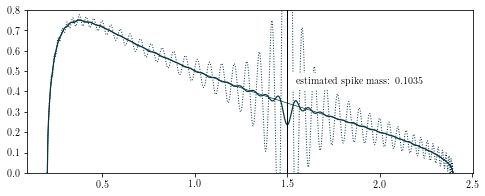

In [10]:
xx = np.linspace(np.min(intervals),np.max(intervals),5000)

fig,axs = plt.subplots(1,1,figsize=(8,3),sharey=True)
axs = [axs]

AQ_U = eval_poly(xx,np.mean(mU,axis=0),αU,βU)
AQ_2 = eval_poly(xx,np.mean(m2,axis=0),α2,β2)

axs[0].plot(xx,AQ_U*mu(xx,a,b),color='#073642',ls=':',lw=1)
axs[0].plot(xx,AQ_2*mu2(xx),color='#073642',ls='-',lw=1.2)

axs[0].plot(xx,mu_mp(xx,d)*(1-nz/n),color='#073642',lw=.7)
    
#for l in np.reshape(intervals_raw,-1):

axs[0].axvline(z,color='k',lw=1)
plt.text(z+.05,.45,\
         f'estimated spike mass: {eval_poly(np.array(z,dtype=np.double),np.mean(m2,axis=0),α2,β2)*weights[0]:1.4f}',\
        horizontalalignment='left',verticalalignment='center',bbox={'fc':'white','ec':'None'})

axs[0].set_ylim(0,.8)

plt.savefig('imgs/RM_AQ_spiked.pdf',bbox_inches='tight')